In [1]:
import networkx as nx
import warnings
import datetime
import seaborn as sn
sn.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from ast import literal_eval
%matplotlib inline
warnings.filterwarnings('ignore')

In [351]:
hour = '20'
# scenario = "Scenario1-Weekday/"
# scenario = "Scenario2-Weekday/"
# scenario = "Scenario1-Saturday/"
scenario = "Scenario2-Saturday/"

# filename = "/passengers_R_H"
# filename = "/passengers_M_H"
# filename = "/passengers_RS_H"
filename = "/passengers_MS_H"

path = "../../Results/" + scenario + hour + filename + hour + "_I"

df1 = pd.read_csv(path + "1.csv")
df2 = pd.read_csv(path + "2.csv")
df3 = pd.read_csv(path + "3.csv")
df4 = pd.read_csv(path + "4.csv")
df5 = pd.read_csv(path + "5.csv")
df6 = pd.read_csv(path + "6.csv")
df7 = pd.read_csv(path + "7.csv")
df8 = pd.read_csv(path + "8.csv")
df9 = pd.read_csv(path + "9.csv")
df10 = pd.read_csv(path + "10.csv")

dflist = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]

In [352]:
ordestcounter = Counter()

for i, df in enumerate(dflist):
    transfertrips = dflist[i][dflist[i]['transfers'] > 0]
    transfertrips['transferstations'] = transfertrips['transferstations'].apply(lambda x: literal_eval(x))
    transfertrips['route'] = transfertrips['route'].apply(lambda x: literal_eval(x))
    split_lists = []

    for index, row in transfertrips.iterrows():
        route = row['route']
        indexes = []

        for transfer in row['transferstations']:
            split = route.index((transfer)) + 1
            indexes.append(split)

        start = 0

        for index in indexes:
            split_lists.append(route[start:index])
            start = index - 1
        split_lists.append(route[start:])
        ordest = []

    for i in range(len(split_lists)):
        ordest.append((split_lists[i][0], split_lists[i][-1]))

    ordestcounter = ordestcounter + Counter(ordest)

In [353]:
ordestcounter = {k: v / 10 for k, v in ordestcounter.items()}

In [463]:
herbest = pd.read_csv('../../Data/20190403/Datalab_Rit_Herkomst_Bestemming_Uur_20190403.csv', sep=';')

In [464]:
# List of all stations in the sub-network
stations = ['Amsteldijk','Amstelstation','Amstelveenseweg','Beethovenstraat','Bullewijk','Burg.de Vlugtlaan', 
    'Centraal Station','Cornelis Troostplein','Dam','De Boelelaan/VU','De Pijp','Europaplein',
    'Gaasperplas','Gein','Gerrit v.d. Veenstraat','Heemstedestraat','Henk Sneevlietweg','IJsbaanpad', 
    'Isolatorweg','Jan v.Galenstraat','Keizersgracht','Koningsplein','Kraaienneststation','Leidseplein',
    'Maasstraat','Marie Heinekenplein','Minervaplein','Muntplein','Museumplein','Nieuwezijds Kolk',
    'Nieuwmarkt','Noord','Noorderpark','Olympiaplein','Olympiaweg','Olympisch stadion','Overamstel', 
    'Postjesweg','Prinsengracht','Reigersbos','Rijksmuseum','Roelof Hartplein','Rokin','Scheldestraat',
    'Spaklerweg','Spui','Station Bijlmer ArenA','Station Diemen-Zuid','Station Duivendrecht', 'Stadionweg'
    'Station Ganzenhoef','Station Holendrecht','Station Lelylaan','Station RAI','Station Sloterdijk', 
    'Strandvliet','Van Baerlestraat','Van der Madeweg','Venserpolder','Verrijn Stuartweg','Victorieplein', 
    'Vijzelgracht','VU medisch centrum','Waalstraat','Waterlooplein','Weesperplein','Wibautstraat','Station Zuid']

In [465]:
herbest['Datum'] = herbest['Datum'].apply(lambda x: datetime.datetime.strptime(x[:-3], '%m/%d/%Y %H:%M:%S'))
herbest['Weekdag'] = herbest['Datum'].apply(lambda x: x.isoweekday())

In [466]:
herbest = herbest[(herbest['Datum'] >= datetime.datetime(2018, 8, 6)) &
                 (herbest['Datum'] < datetime.datetime(2019, 3, 25))]

In [467]:
herbest = herbest[(herbest['VertrekHalteNaam'].isin(stations)) & (herbest['Weekdag'].isin([6]))]
herbest = herbest[(herbest['AankomstHalteNaam'].isin(stations))]

In [468]:
herbest = herbest[herbest['UurgroepOmschrijving (van vertrek)'] == '08:00 - 08:59']
herbest.head()

,Datum,UurgroepOmschrijving (van vertrek),VertrekHalteCode,VertrekHalteNaam,VertrekLat,VertrekLon,AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalRitten,Weekdag
4720153,2018-08-11 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,05062,Spui,4.889259,52.369097,30,6
4720154,2018-08-11 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,05065,Dam,4.890794,52.373678,22,6
4720155,2018-08-11 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,05070,Nieuwezijds Kolk,4.892841,52.375754,17,6
4720159,2018-08-11 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,06072,Prinsengracht,4.884284,52.364959,11,6
4720160,2018-08-11 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,06074,Keizersgracht,4.886241,52.365884,10,6


In [469]:
stopdict = {'ITW': 1, 'GN': 1, 'RAI': 1, 'VSW': 1, 'ND': 1, 'RKN': 1, 
            'WPP': 1, 'RGB': 1, 'HVW': 1, 'OAS': 1, 'CLL': 1, 'PJW': 1, 
            'BLW': 1, 'WBS': 1, 'HLD': 1, 'MDW': 1, 'SVT': 1, 'DMZ': 1, 
            'BMR': 1, 'EPP': 1, 'WTC': 1, 'DPP': 1, 'JLS': 1, 'DVD': 1, 
            'GZH': 1, 'NDP': 1, 'NMT': 1, 'VLN': 1, 'ASA': 1, 'KEN': 1, 
            'VPD': 1, 'SLW': 1, 'WLP': 1, 'HDS': 1, 'GPP': 1, 'VZG': 1, 
            'CS': 1, 'VU': 1, 'ASW': 1, 'STD': 1, '08070': 1, '09122': 1, 
            '09121': 1, '07094': 1, '07091': 1, '08071': 1, '09013': 1, 
            '07004': 1, '08076': 1, '08078': 1, '07307': 1, '07308': 1, 
            '07120': 2, '07108': 2, '09083': 2, '09082': 2, '07202': 2, 
            '07121': 2, '09078': 2, '09079': 2, '07084': 2, '07083': 2, 
            '07207': 2, '07205': 2, '07017': 2, '07303': 2, '07350': 2, 
            '09074': 2, '09075': 2, '07098': 2, '07097': 2, '07493': 2, 
            '07490': 2, '09119': 2, '09120': 2, '05036': 3, '05035': 3, 
            '06072': 3, '06071': 3, '06075': 3, '06076': 3, '06073': 3, 
            '06074': 3, '07015': 3, '09049': 3, '09051': 3, '05062': 3, 
            '05061': 3, '07006': 3, '07007': 3, '07322': 3, '07321': 3, 
            '07323': 3, '07324': 3, '06067': 3, '05063': 3, '05032': 3, 
            '05031': 3, '07016': 0.6666666666666666, '09114': 0.6666666666666666, 
            '09111': 0.6666666666666666, '09139': 4, '09140': 4, '05022': 4, 
            '05011': 5, '06089': 5, '05065': 5, '05070': 5, '05069': 5}

In [470]:
herbest = herbest[herbest['VertrekHalteCode'].isin(stopdict.keys())]
herbest = herbest[herbest['AankomstHalteCode'].isin(stopdict.keys())]
herbest = herbest[herbest['AankomstHalteNaam'] != herbest['VertrekHalteNaam']]

In [471]:
herbest['AantalLijnenVertrek'] = herbest['VertrekHalteCode'].map(stopdict)
herbest['AantalLijnenAankomst'] = herbest['AankomstHalteCode'].map(stopdict)
herbest['AantalLijnen'] = np.where(herbest.AantalLijnenVertrek > herbest.AantalLijnenAankomst, 
         herbest.AantalLijnenAankomst, herbest.AantalLijnenVertrek)

In [472]:
herbest['AantalRittenNorm'] = herbest['AantalRitten']/herbest['AantalLijnen']

In [473]:
herbest.head(5)

,Datum,UurgroepOmschrijving (van vertrek),VertrekHalteCode,VertrekHalteNaam,VertrekLat,VertrekLon,AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalRitten,Weekdag,AantalLijnenVertrek,AantalLijnenAankomst,AantalLijnen,AantalRittenNorm
4720153,2018-08-11 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,05062,Spui,4.889259,52.369097,30,6,5.0,3.0,3.0,10.000000
4720154,2018-08-11 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,05065,Dam,4.890794,52.373678,22,6,5.0,5.0,5.0,4.400000
4720155,2018-08-11 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,05070,Nieuwezijds Kolk,4.892841,52.375754,17,6,5.0,5.0,5.0,3.400000
4720159,2018-08-11 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,06072,Prinsengracht,4.884284,52.364959,11,6,5.0,3.0,3.0,3.666667
4720160,2018-08-11 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,06074,Keizersgracht,4.886241,52.365884,10,6,5.0,3.0,3.0,3.333333


In [474]:
datadict = {}
for index, row in herbest.iterrows():
    datadict[(row['VertrekHalteNaam'], row['AankomstHalteNaam'])] = row['AantalRittenNorm']

In [475]:
iets = pd.read_csv('../../Results/subtrips8.csv')
from ast import literal_eval
iets['stations'] = [literal_eval(x) for x in iets['stations']]
iets

,stations,sc1week,gvb,sc2week,sc1weekend,sc2weekend
0,"(Station Diemen-Zuid, Amstelstation)",26.6,111.000000,20.7,8.8,7.4
1,"(Amstelstation, De Pijp)",411.9,27.000000,205.2,54.7,38.1
2,"(De Pijp, Centraal Station)",206.2,249.000000,216.1,22.4,29.9
3,"(Station Sloterdijk, Station Zuid)",235.0,449.000000,229.1,38.7,32.9
4,"(Station Zuid, Centraal Station)",830.3,216.000000,836.1,99.7,132.3
5,"(Centraal Station, Weesperplein)",408.1,1359.000000,394.6,20.3,19.1
6,"(Vijzelgracht, Station Zuid)",87.2,252.000000,89.2,9.9,12.6
7,"(Station Zuid, Amstelveenseweg)",224.6,224.000000,224.3,27.6,26.8
8,"(Amstelveenseweg, Roelof Hartplein)",81.7,0.000000,82.1,4.5,15.7
9,"(Roelof Hartplein, De Pijp)",69.7,16.500000,51.5,10.9,8.5


In [476]:
data = pd.DataFrame.from_dict(datadict, orient='index')
data = data.reset_index()

In [477]:
data.head(5)

,index,0
0,"(Centraal Station, Spui)",8.000000
1,"(Centraal Station, Dam)",11.333333
2,"(Centraal Station, Nieuwezijds Kolk)",3.600000
3,"(Centraal Station, Prinsengracht)",9.000000
4,"(Centraal Station, Keizersgracht)",5.000000


In [478]:
iets.head(5)

,stations,sc1week,gvb,sc2week,sc1weekend,sc2weekend
0,"(Station Diemen-Zuid, Amstelstation)",26.6,111.0,20.7,8.8,7.4
1,"(Amstelstation, De Pijp)",411.9,27.0,205.2,54.7,38.1
2,"(De Pijp, Centraal Station)",206.2,249.0,216.1,22.4,29.9
3,"(Station Sloterdijk, Station Zuid)",235.0,449.0,229.1,38.7,32.9
4,"(Station Zuid, Centraal Station)",830.3,216.0,836.1,99.7,132.3


In [479]:
iets.columns

Index(['stations', 'sc1week', 'gvb', 'sc2week', 'sc1weekend', 'sc2weekend'], dtype='object')

In [480]:
iets = iets.merge(data, left_on='stations', right_on='index', how='outer')

In [481]:
iets.columns = ['stations', 'sc1week', 'gvb', 'sc2week', 'sc1weekend', 'sc2weekend', 'stations2', 'gvbweekend']

In [482]:
iets.stations.fillna(iets.stations2, inplace=True)

In [483]:
iets = iets.fillna(value=0)
del iets['stations2']
iets.head(5)

,stations,sc1week,gvb,sc2week,sc1weekend,sc2weekend,gvbweekend
0,"(Station Diemen-Zuid, Amstelstation)",26.6,111.0,20.7,8.8,7.4,10.0
1,"(Amstelstation, De Pijp)",411.9,27.0,205.2,54.7,38.1,19.5
2,"(De Pijp, Centraal Station)",206.2,249.0,216.1,22.4,29.9,47.0
3,"(Station Sloterdijk, Station Zuid)",235.0,449.0,229.1,38.7,32.9,25.0
4,"(Station Zuid, Centraal Station)",830.3,216.0,836.1,99.7,132.3,57.0


In [484]:
iets.to_csv('../../Results/subtrips8.csv', index=False)

In [355]:
simulation = pd.DataFrame.from_dict(ordestcounter, orient='index')
simulation = simulation.reset_index()

In [356]:
simulation.head(5)

,index,0
0,"(Dam, Rokin)",150.1
1,"(Rokin, Centraal Station)",159.3
2,"(Muntplein, Vijzelgracht)",27.1
3,"(Vijzelgracht, Rokin)",10.9
4,"(Centraal Station, Van der Madeweg)",223.3


In [324]:
# combined = simulation.merge(data, on='index', how='outer')

In [325]:
# combined.columns = ['stations', 'sc1week', 'gvb']

In [357]:
combined = combined.merge(simulation, left_on='stations', right_on='index', how='outer')

In [362]:
combined.columns = ['stations','sc1week','gvb','sc2week', 'sc1weekend','stations2', 'sc2weekend']

In [363]:
combined = combined.fillna(value=0)

In [364]:
combined.stations.fillna(combined.stations2, inplace=True)

In [365]:
del combined['stations2']

In [366]:
combined.head()

,stations,sc1week,gvb,sc2week,sc1weekend,sc2weekend
0,"(Amstelstation, De Pijp)",109.2,21.0,70.2,140.6,72.2
1,"(De Pijp, Station Zuid)",153.7,87.0,143.1,201.0,192.3
2,"(Station Zuid, Station Bijlmer ArenA)",87.2,40.0,101.8,159.1,156.2
3,"(Prinsengracht, De Pijp)",7.0,0.0,11.5,13.4,16.3
4,"(Station Sloterdijk, Station Zuid)",28.4,17.0,26.2,39.2,32.9


In [64]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from math import sqrt
# mean_absolute_error(combined['data8'], combined['simulation8'])

35.91525821596244

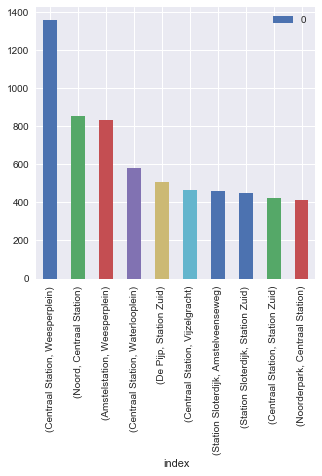

In [65]:
dataplot = (data.sort_values(by = 0, ascending = False)).head(10)
dataplot.plot(kind = 'bar', x = 'index', y = 0, figsize = [5,5])

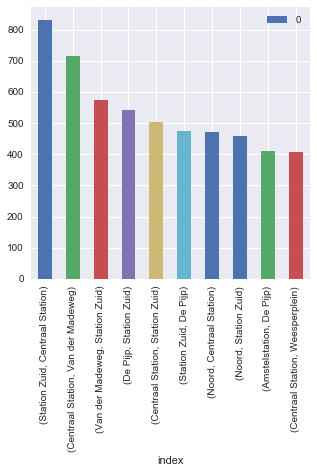

In [66]:
simulationplot = (simulation.sort_values(by = 0, ascending = False)).head(10)
simulationplot.plot(kind = 'bar', x = 'index', y = 0, figsize = [5,5])